# Causal Effects via Regression



What is the effect of going to a fancy college on later-life earnings? We'll use data on about 1,000 American men in the NLSY born 1980-1984 who finished college, and look at the effect of going to a private college ($D_i$) on earnings ($Y_i$) in 2015-2019 (when they were about 30-39 years old). We will be estimating an equation like this:

$$
Y_i = \delta D_i + X_i'\beta+\varepsilon_i,
$$

where $X_i$ is a vector of controls, conditional on which we are willing to assume $D_i$ is as good as randomly assigned.

What kinds of variables should we include in $X_i$?


In [3]:
# import useful packages
import pandas as pd  # for loading and managing datasets
import statsmodels.api as sm  # for running regressions and getting standard errors

In [8]:
# load NLSY data
nlsy = pd.read_csv(
    "https://github.com/Mixtape-Sessions/Heterogeneous-Effects/raw/main/Labs/data/nlsy97.csv"
)
nlsy

,asvab,annualearnings,privatecollege,dadcollege,momcollege
0,44451,20000.000,0,0,0
1,62806,85000.000,1,0,0
2,59270,50000.000,0,0,0
3,45900,12960.000,1,0,0
4,44217,NaN,0,0,0
...,...,...,...,...,...
1163,15283,25500.000,0,0,0
1164,28236,40000.000,0,0,0
1165,71393,135000.000,0,0,0
1166,27785,31666.666,0,1,0


In [9]:
# clean data (drop obs with missing values)
nlsy = nlsy.dropna()
nlsy

,asvab,annualearnings,privatecollege,dadcollege,momcollege
0,44451,20000.000,0,0,0
1,62806,85000.000,1,0,0
2,59270,50000.000,0,0,0
3,45900,12960.000,1,0,0
6,73429,32000.000,1,1,1
...,...,...,...,...,...
1163,15283,25500.000,0,0,0
1164,28236,40000.000,0,0,0
1165,71393,135000.000,0,0,0
1166,27785,31666.666,0,1,0


Let's start with a simple (uncontrolled) regression.


In [10]:
# Simple regression
rhs = sm.add_constant(
    nlsy["privatecollege"]
)  # you have to add the constant yourself with statsmodels!
model = sm.OLS(nlsy["annualearnings"], rhs)
results = model.fit(cov_type="HC3")  # heteroskedasticity-robust
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         annualearnings   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     5.512
Date:                Sat, 02 Dec 2023   Prob (F-statistic):             0.0191
Time:                        11:01:37   Log-Likelihood:                -12688.
No. Observations:                1031   AIC:                         2.538e+04
Df Residuals:                    1029   BIC:                         2.539e+04
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           7.281e+04   2009.484     36.

How to interpret the coefficient on $privatecollege$? As a causal effect?


Now let's add controls for parent's education and cognitive ability as measured by ASVAB:


In [11]:
# Regression with controls
rhs = sm.add_constant(nlsy[["privatecollege", "dadcollege", "momcollege", "asvab"]])
model = sm.OLS(nlsy["annualearnings"], rhs)
results = model.fit(cov_type="HC3")
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         annualearnings   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     15.97
Date:                Sat, 02 Dec 2023   Prob (F-statistic):           1.08e-12
Time:                        11:01:39   Log-Likelihood:                -12662.
No. Observations:                1031   AIC:                         2.533e+04
Df Residuals:                    1026   BIC:                         2.536e+04
Df Model:                           4                                         
Covariance Type:                  HC3                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           4.357e+04   3796.743     11.

How did the inclusion of controls change the estimate? Why?


Back to the whiteboard for prediction!


# Prediction Primer


Let's use decision trees to predict which participants of the National JTPA Study were likely to find a job. We will use prior earnings, education, sex, race, and marital status as our prediction features.


In [12]:
data = pd.read_csv(
    "https://github.com/Mixtape-Sessions/Heterogeneous-Effects/raw/main/Labs/data/jtpahet.csv"
)
data

,age,enroll,priorearn,educ,female,nonwhite,z,married,foundjob
0,46,1,0,12,1,1,1,0,1
1,24,1,3591,11,1,0,1,0,1
2,28,1,6000,9,0,1,1,1,1
3,23,0,2000,11,0,0,0,1,1
4,34,0,0,12,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...
13848,26,0,0,12,1,1,0,1,0
13849,52,0,0,10,0,0,1,0,0
13850,32,0,0,12,1,1,0,0,0
13851,16,1,0,9,0,1,1,0,0


Import some utilities:


In [15]:
import requests

url1 = "https://github.com/Mixtape-Sessions/Heterogeneous-Effects/raw/main/Labs/python/plot_2d_separator.py"
r1 = requests.get(url1)

r1.text

'import numpy as np\nimport matplotlib.pyplot as plt\nfrom plot_helpers import cm2, cm3, discrete_scatter\n\ndef _call_classifier_chunked(classifier_pred_or_decide, X):\n    # The chunk_size is used to chunk the large arrays to work with x86\n    # memory models that are restricted to < 2 GB in memory allocation. The\n    # chunk_size value used here is based on a measurement with the\n    # MLPClassifier using the following parameters:\n    # MLPClassifier(solver=\'lbfgs\', random_state=0,\n    #               hidden_layer_sizes=[1000,1000,1000])\n    # by reducing the value it is possible to trade in time for memory.\n    # It is possible to chunk the array as the calculations are independent of\n    # each other.\n    # Note: an intermittent version made a distinction between\n    # 32- and 64 bit architectures avoiding the chunking. Testing revealed\n    # that even on 64 bit architectures the chunking increases the\n    # performance by a factor of 3-5, largely due to the avoidanc

In [39]:
# @title
import requests
url1 = 'https://github.com/Mixtape-Sessions/Heterogeneous-Effects/raw/main/Labs/python/plot_2d_separator.py'
url2 = 'https://github.com/Mixtape-Sessions/Heterogeneous-Effects/raw/main/Labs/python/plot_interactive_tree.py'
url3 = 'https://github.com/Mixtape-Sessions/Heterogeneous-Effects/raw/main/Labs/python/plot_helpers.py'
url4 = 'https://github.com/Mixtape-Sessions/Heterogeneous-Effects/raw/main/Labs/python/tools.py'
r1 = requests.get(url1)
r2 = requests.get(url2)
r3 = requests.get(url3)
r4 = requests.get(url4)

# make sure your filename is the same as how you want to import
with open('plot_2d_separator.py', 'w') as f1:
    f1.write(r1.text)

with open('plot_interactive_tree.py', 'w') as f2:
    f2.write(r2.text)

with open('plot_helpers.py', 'w') as f3:
    f3.write(r3.text)

with open('tools.py', 'w') as f4:
    f4.write(r4.text)

# now we can import
import plot_helpers
import tools
import plot_2d_separator
import plot_interactive_tree

In [40]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

plt.style.use("seaborn-whitegrid")
from sklearn.tree import plot_tree

We'll first grow a tree using just two features (education and prior earnings) so we can visualize it easily. Let's visualize the feature space: triangles are individuals who found a job, circles are those who didn't.


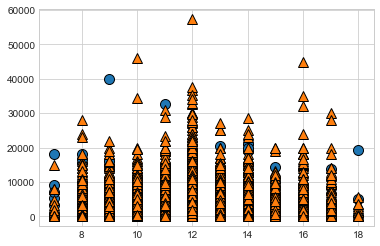

In [41]:
plot_helpers.discrete_scatter(
    data.loc[:, "educ"].values,
    data.loc[:, "priorearn"].values,
    data.loc[:, "foundjob"].values,
)
plt.show()

<AxesSubplot:>

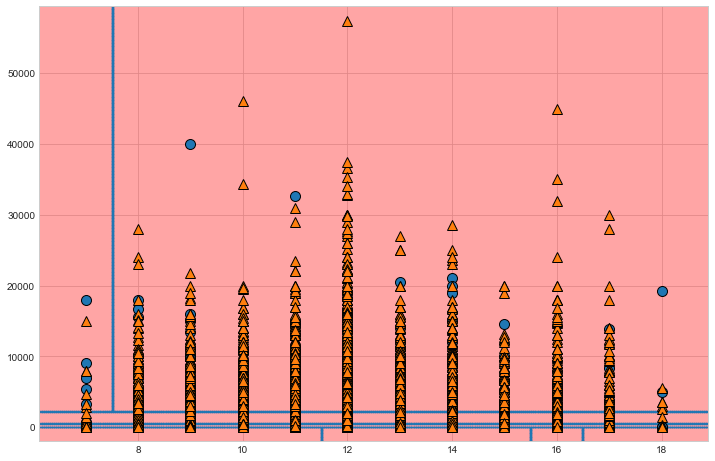

In [42]:
tree = DecisionTreeRegressor(max_depth=3).fit(
    data.loc[:, ["educ", "priorearn"]].values, data.loc[:, "foundjob"].values
)
fig1, ax = plt.subplots(1, 1, figsize=(12, 8))
plot_interactive_tree.plot_tree_partition(
    data.loc[:, ["educ", "priorearn"]].values,
    data.loc[:, "foundjob"].values,
    tree,
    ax=ax,
)


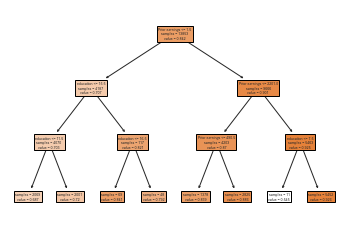

In [43]:
plot_tree(
    tree,
    feature_names=["education", "Prior earnings"],
    class_names=["No job", "Found job"],
    impurity=False,
    filled=True,
)
plt.show()

Now let's do a random forest:


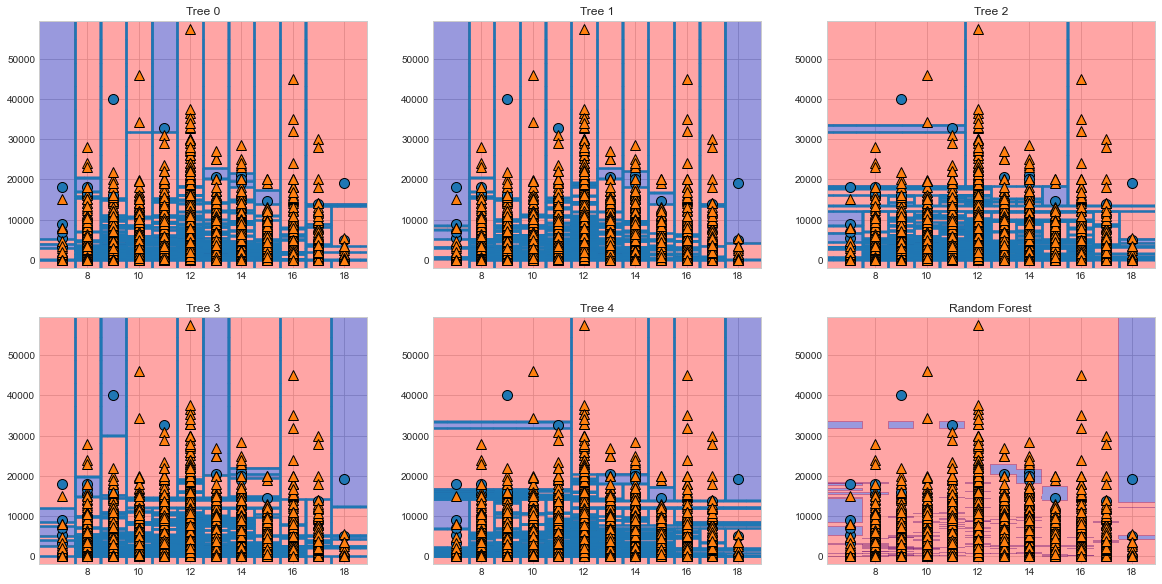

In [44]:
forest = RandomForestClassifier(n_estimators=5, random_state=2).fit(
    data.loc[:, ["educ", "priorearn"]].values, data.loc[:, "foundjob"].values
)

fig, axes = plt.subplots(2, 3, figsize=(20, 10))
for i, (ax, tree) in enumerate(zip(axes.ravel(), forest.estimators_)):
    ax.set_title("Tree {}".format(i))
    plot_interactive_tree.plot_tree_partition(
        data.loc[:, ["educ", "priorearn"]].values,
        data.loc[:, "foundjob"].values,
        tree,
        ax=ax,
    )

plot_2d_separator.plot_2d_separator(
    forest,
    data.loc[:, ["educ", "priorearn"]].values,
    fill=True,
    ax=axes[-1, -1],
    alpha=0.4,
)
axes[-1, -1].set_title("Random Forest")
plot_helpers.discrete_scatter(
    data.loc[:, "educ"].values,
    data.loc[:, "priorearn"].values,
    data.loc[:, "foundjob"].values,
)
plt.show()

We only used two prediction features (prior earnings and education) for visualization. To get the best predictions, we should use all of our features. And to evaluate the quality of the prediction, we should hold out a test set.


In [45]:
# Define a matrix of features:
X = data[["age", "priorearn", "educ", "female", "nonwhite", "married"]]
# hold out a test test:
X_train, X_test, y_train, y_test = train_test_split(
    X, data["foundjob"], random_state=42
)

Try on your own: grow a forest with 500 trees using the training set, and evaluate the prediction accuracy on the test set. Hint: you can evaluate the prediction accuracy by doing `forest.score(X_test,y_test)`.


##Cheat


In [23]:
forest = RandomForestClassifier(n_estimators=500, random_state=2).fit(X_train, y_train)
forest.score(X_test, y_test)

0.8201501154734411

So much for predicting _outcomes_. We want to predict causal effects. Back to the whiteboard!


# Using Machine Learning to Predict Heterogeneous Treatment Effects


## Key Challenge: Algorithms tailored for predicting outcomes can do poorly when predicting treatment effects


### Factors that strongly predict outcomes may not strongly predict treatment effects


$Y_i$: spending on a Lexus

$D_i$: seeing an online ad for a Lexus

$\ln Y_i=\beta_0+\beta_1 age_i +\beta_2 male_i + \beta_3 D_i+\beta_4 D_i \times male_i +\varepsilon_i$

How do outcomes vary by age? (A lot if $\beta_1$ is big)

How do treatment effects vary by age? (not at all!)

What do treatment effects vary by? (gender!)


Let's simulate some data to show what happens when we try to use algorithm tailored to predicting outcomes for predicting treatment effects.


In [13]:
import numpy as np
from sklearn import tree

In [46]:
# define parameters
n = 1000  # sample size
p = 0.5  # probability of seeing the ad
beta0 = 0
beta1 = 0.2  # effect of age
beta2 = (
    -0.025
)  # difference in average spending between males and females who don't see the ad ()
beta3 = 0  # effect of treatment among females
beta4 = 0.05  # differential effect of treatment among males compared to females
sigeps = 0.02  # residual variance of outcome

# generate some fake data
age = np.random.randint(low=18, high=61, size=(n, 1))
male = np.random.randint(low=0, high=2, size=(n, 1))
d = np.random.rand(n, 1) > (1 - p)
epsilon = sigeps * np.random.randn(n, 1)
lny = beta0 + beta1 * age + beta2 * male + beta3 * d + beta4 * d * male + epsilon

# assemble as dataframe
fakedata = pd.DataFrame(
    np.concatenate((lny, d, age, male), axis=1), columns=["lny", "d", "age", "male"]
)
fakedata.feature_names = ["age", "male"]
x0 = fakedata.loc[d == 0, ["age", "male"]]
x1 = fakedata.loc[d == 1, ["age", "male"]]
y0 = fakedata.loc[d == 0, ["lny"]]
y1 = fakedata.loc[d == 1, ["lny"]]

Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


Try on your own: fit two trees (call them `tree0` and `tree1`), each with `max_depth=2` to predict the outcome separately in the untreated ($D_i=0$) and treated ($D_i=1$) samples, using `x0` and `x1`, respectively.


In [47]:
# fit trees

In [48]:
# display trees

### Cheat


In [49]:
# fit trees
tree1 = DecisionTreeRegressor(max_depth=2).fit(x1, y1)
tree0 = DecisionTreeRegressor(max_depth=2).fit(x0, y0)

Treated tree:


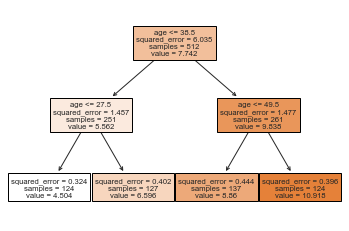

In [50]:
# display trees
print("Treated tree:")
plot_tree(tree1, filled=True, feature_names=fakedata.feature_names)
plt.show()

Untreated tree:


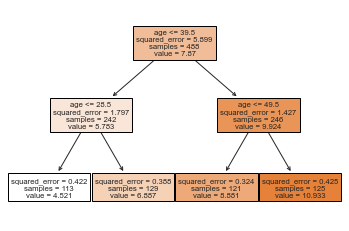

In [51]:
print("Untreated tree:")
plot_tree(tree0, filled=True, feature_names=fakedata.feature_names)
plt.show()

Which variable(s) did the trees key in on? Why? Would these trees be useful for predicting treatment effects? Why or why not?

How do we fix the problem?


## Random Causal Forest: Simulated Example


In [1]:
# Install econml


Note: you may need to restart the kernel to use updated packages.


La syntaxe de la commande n'est pas correcte.


In [52]:
from econml.dml import CausalForestDML as CausalForest

In [53]:
# NOTE: If you are getting `np.int` error, do the following:
# pip install --force-reinstall numpy==1.23.5
# There is a fix for the new numpy version, but it's not released yet:
# https://github.com/py-why/EconML/commit/0be16255f10853fc9fe0774cb5649e051dc55dff

# Instantiate the Causal Forest
estimator = CausalForest(n_estimators=500, discrete_treatment=True, criterion="het")

# Grow the forest
estimator.fit(
    fakedata["lny"], fakedata["d"], X=fakedata[["age", "male"]]  # outcome  # treatment
)  # prediction features

# Predict effects for each observation based on its characteristics:
effects = estimator.effect(fakedata[["age", "male"]])

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


Let's see how well it did at estimating effects among men and women:


In [54]:
malefx = effects[fakedata["male"].values == 1]
malefx.mean()

0.04625555697484175

In [55]:
femalefx = effects[fakedata["male"].values == 0]
femalefx.mean()

0.001573055518916351

How did our causal forest do at getting effects right for men and women? Let's see how it does on the age profile:


Text(0, 0.5, 'treatment effect')

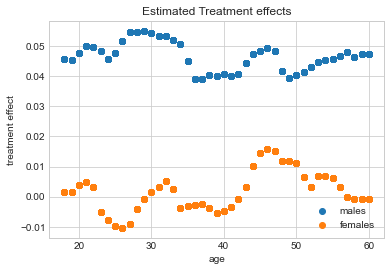

In [56]:
fig = plt.figure()
ax = plt.axes()
maleage = fakedata["age"].iloc[fakedata["male"].values == 1]
femaleage = fakedata["age"].iloc[fakedata["male"].values == 0]

ax.scatter(maleage, malefx, label="males")
ax.scatter(femaleage, femalefx, label="females")
ax.legend()
plt.title("Estimated Treatment effects")
plt.xlabel("age")
plt.ylabel("treatment effect")

A little noisy on the age profile (which should be flat) but does get the difference between men and women!


## Random Causal Forest: Predict the effects of job training


We are ready to apply machine learning to predict causal effects in a real-life setting: how do the effects of job training vary by an individual's characteristics? We will use data from the National Job Training Partnership study, a large-scale randomized evaluation of a publicly subsidized job training program for disadvantaged youth and young adults. Why would we care how the effects of a subsidized job training program vary by a person's characteristics?


We will use the JTPA evaluation dataset, which contains observations on about 14,000 individuals, some of whom were randomized to participate in job training ($z_i = 1$) and others who were not ($z_i = 0$).

To do on your own:

- load the dataset from the url `https://github.com/Mixtape-Sessions/Heterogeneous-Effects/raw/main/Labs/data/jtpahet.csv`
- define the outcome vector (call it `y`) to be the column labeled `foundjob`
- define the randomized assignment indicator (call it `z`) to be the column labeled `z`
- define the feature vector (call it `x`) to be all columns except `foundjob`, `z`, and `enroll`.


In [57]:
# load the data

# define the variables

### Cheat


In [58]:
data = pd.read_csv(
    "https://github.com/Mixtape-Sessions/Heterogeneous-Effects/raw/main/Labs/data/jtpahet.csv"
)
data

,age,enroll,priorearn,educ,female,nonwhite,z,married,foundjob
0,46,1,0,12,1,1,1,0,1
1,24,1,3591,11,1,0,1,0,1
2,28,1,6000,9,0,1,1,1,1
3,23,0,2000,11,0,0,0,1,1
4,34,0,0,12,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...
13848,26,0,0,12,1,1,0,1,0
13849,52,0,0,10,0,0,1,0,0
13850,32,0,0,12,1,1,0,0,0
13851,16,1,0,9,0,1,1,0,0


In [59]:
y = data["foundjob"]
z = data["z"]
x = data.drop(["foundjob", "z", "enroll"], axis=1)
x

,age,priorearn,educ,female,nonwhite,married
0,46,0,12,1,1,0
1,24,3591,11,1,0,0
2,28,6000,9,0,1,1
3,23,2000,11,0,0,1
4,34,0,12,1,1,1
...,...,...,...,...,...,...
13848,26,0,12,1,1,1
13849,52,0,10,0,0,0
13850,32,0,12,1,1,0
13851,16,0,9,0,1,0


### Regression to get average effect


On your own: run a linear regression of the outcome on the random assignment indicator, `z`. Since this was a randomized experiment, we don't need controls!


### Cheat:


In [60]:
rhs = sm.add_constant(
    data["z"]
)  # you have to add the constant yourself with statsmodels!
model = sm.OLS(data["foundjob"], rhs)
results = model.fit(cov_type="HC3")  # heteroskedasticity-robust
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               foundjob   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     7.691
Date:                Sun, 03 Dec 2023   Prob (F-statistic):            0.00556
Time:                        10:01:06   Log-Likelihood:                -5663.4
No. Observations:               13853   AIC:                         1.133e+04
Df Residuals:                   13851   BIC:                         1.135e+04
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8297      0.006    146.446      0.0

### Set up random forest


So far, so good? Now create a random causal forest object, and fit it with outcome `y`, treatment variable `z`, and feature matrix `x`.


In [61]:
# On your own: create and fit random causal forest object

### Cheat


In [62]:
rcf = CausalForest(n_estimators=1000, discrete_treatment=True, criterion="het").fit(
    y, z, X=x
)

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
Objective did not converge. You might want t

Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
Objective did not converge. You might want to increase the number of iterations. Duality

### Explore effects


Let's see what kind of heterogeneous effects our random causal forest predicted


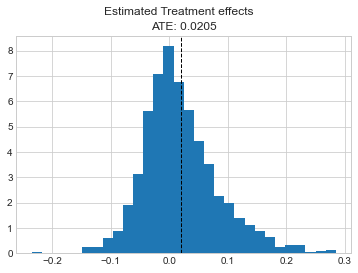

In [63]:
# calculate the predicted effects:
insamplefx = rcf.effect(x)
# plot a histogram of the estimated effects, with average effect overlaid
fig = plt.figure()
ax = plt.axes()
ax.hist(insamplefx, bins=30, density=True)
plt.axvline(rcf.ate_, color="k", linestyle="dashed", linewidth=1)
plt.suptitle("Estimated Treatment effects")
plt.title("ATE: {:.3g}".format(rcf.ate_[0]))
plt.show()

Let's visualize how these effects vary by prior earnings and education by making a heatmap


In [29]:
import itertools

In [64]:
# create a grid of values for education and prior earnings:
educgrid = np.arange(data["educ"].values.min(), data["educ"].values.max() + 1)
earngrid = np.arange(
    data["priorearn"].values.min(), data["priorearn"].values.max(), 5000
)
grid = pd.DataFrame(
    itertools.product(educgrid, earngrid), columns=["educ", "priorearn"]
)

We'll first visualize the effects among married, nonwhite females of average age:


In [65]:
grid["age"] = data["age"].values.mean()  # set age to the average
grid["female"] = 1  # set female = 1
grid["nonwhite"] = 1  # set nonwhite = 1
grid["married"] = 1  # set married = 1

To do on your own: calculate the predicted effects for each "observation" in the grid:


In [66]:
# gridfx = # uncomment and fill in on your own!

### Cheat


In [67]:
gridfx = rcf.effect(grid)

### Visualize effects with a heatmap:


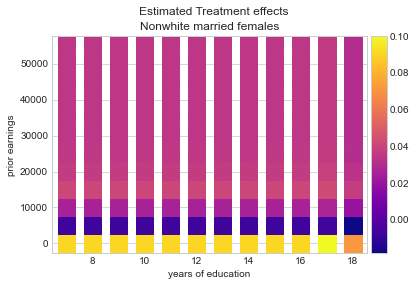

In [68]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure()
ax = plt.subplot()
main = ax.scatter(
    grid["educ"], grid["priorearn"], c=gridfx, cmap="plasma", marker="s", s=300
)
plt.suptitle("Estimated Treatment effects")
plt.title("Nonwhite married females")
plt.xlabel("years of education")
plt.ylabel("prior earnings")

# create an Axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(main, cax=cax)
plt.show()

To do on your own: make similar visualizations for males, singles, whites, different ages, etc.
